# Leveraging Python for Spatial Data Science

#### Install Packages

## Import Packages

In [18]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Retrieve POIs data
import requests
import json

# Geospatial analysis
import geopandas as gpd
import libpysal
import esda

# Walkshed with road network
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from alphashape import alphashape

# NDVI Calculation
import rasterio
import rasterstats as rstats
from rasterio.plot import show

# Plotting
import folium
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import contextily as ctx
from splot import esda as esdaplot

## 1. Geographical V.S. Projected Coordinate Systems
* Commonly-used Coordinate System for D.C.:
    * https://octo.dc.gov/page/coordinate-system-standards
    * https://epsg.io/6487
* Data source: https://www2.census.gov/geo/tiger/TIGER2020/TRACT/

In [3]:
# read census tract boundary in DC
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")

In [4]:
# Check the coordinate system of `dc_census_tract`
dc_census_tract.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [5]:
# Reproject the D.C. boundary data to the projected coordinate system "MD State Plane NAD 83"
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:6487")

In [6]:
dc_census_tract_rprj.crs

<Projected CRS: EPSG:6487>
Name: NAD83(2011) / Maryland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Maryland - counties of Allegany; Anne Arundel; Baltimore; Calvert; Caroline; Carroll; Cecil; Charles; Dorchester; Frederick; Garrett; Harford; Howard; Kent; Montgomery; Prince Georges; Queen Annes; Somerset; St Marys; Talbot; Washington; Wicomico; Worcester.
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

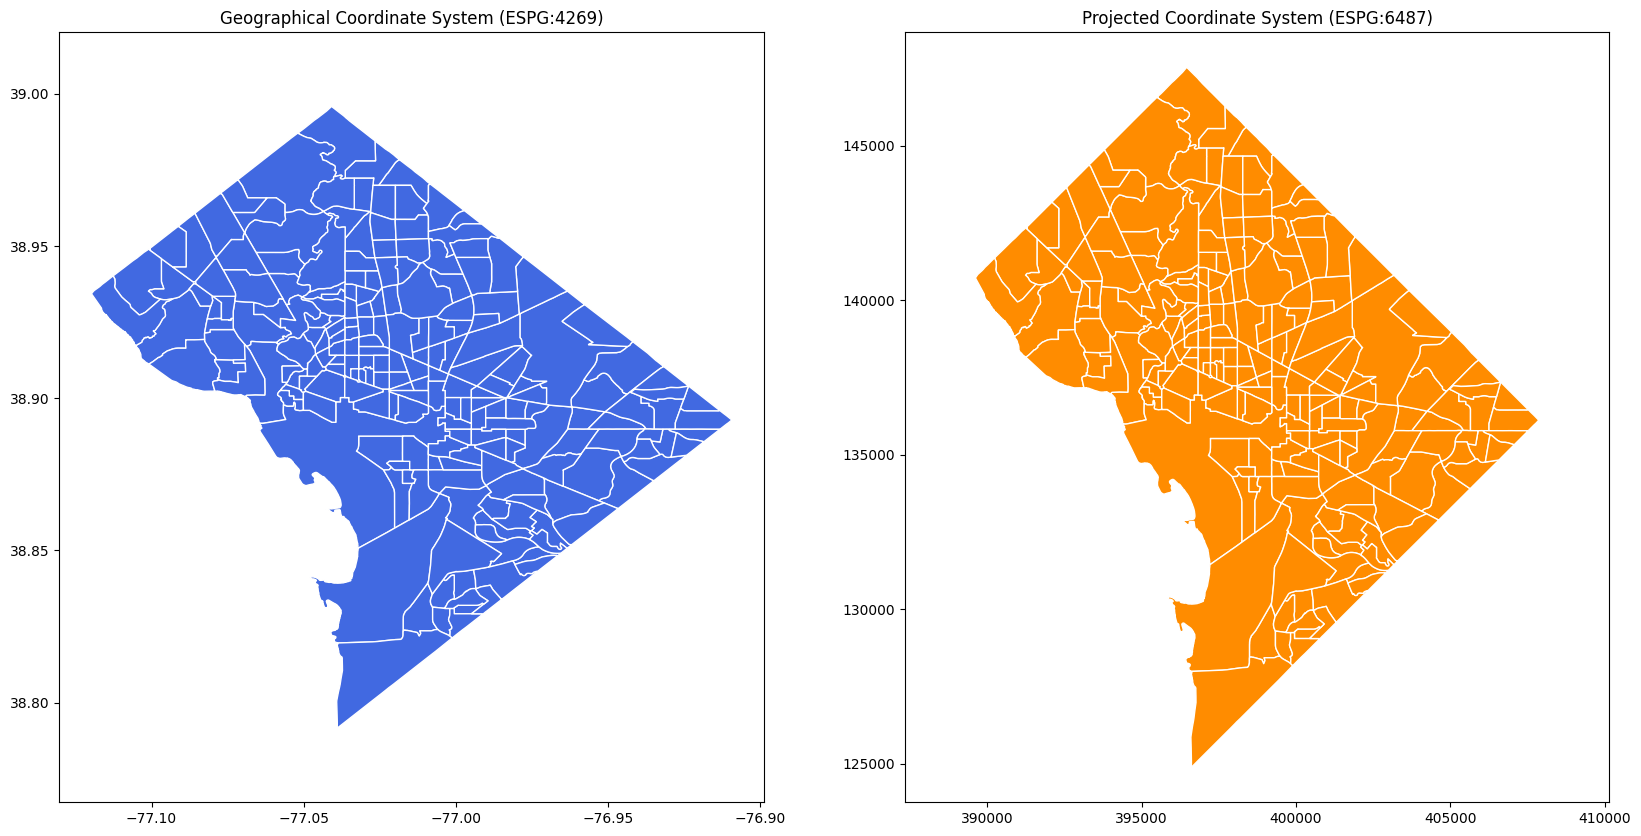

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original coordinate system
dc_census_tract.plot(ax=ax1, color='royalblue', edgecolor='white')
ax1.set_title('Geographical Coordinate System (ESPG:4269)')
ax1.axis('equal')

# Plot the reprojected coordinate system
dc_census_tract_rprj.plot(ax=ax2, color='darkorange', edgecolor='white')
ax2.set_title('Projected Coordinate System (ESPG:6487)')
ax2.axis('equal')

plt.show()

# 2. Eateries in D.C.

## Retrive POIs in D.C.

In [8]:
# Get the bounding box of D.C.
print(dc_census_tract.total_bounds)

[-77.119759  38.791645 -76.909393  38.995845]


In [9]:
# Define the bboxing of Washington, D.C. for POIs query using overpass API
dc_bbox = "38.791645, -77.119759, 38.995845, -76.909393"

In [10]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the Overpass query using the bounding box variable
dc_eatery_overpass_query = f"""
[out:json][timeout:25];

(
  node["amenity"="restaurant"]({dc_bbox});
  node["amenity"="cafe"]({dc_bbox});
  node["amenity"="bar"]({dc_bbox});
  node["amenity"="biergarten"]({dc_bbox});
  node["amenity"="pub"]({dc_bbox});

);
out body;
>;
out skel qt;
"""

# Make the request
dc_eatery_response = requests.get(overpass_url, params={'data': dc_eatery_overpass_query})
dc_eatery_dict = dc_eatery_response.json()

# Convert the data into a pandas DataFrame
dc_eatery_list = [] # Create a list for the initilization of the dataframe
for element in dc_eatery_dict['elements']:
    uid = element['id']
    latitude = element['lat']
    longitude = element['lon']
    name = element.get('tags', {}).get('name', 'n/a')
    amenity = element.get('tags', {}).get('amenity', 'n/a')
    dc_eatery_list.append({
        'UID': uid,
        'Name': name,
        'Type': amenity,
        'Latitude': latitude,
        'Longitude': longitude
    })

# Create the DataFrame using the list
dc_eatery_df = pd.DataFrame(dc_eatery_list)

# Show the DataFrame
dc_eatery_df

UID             Name        Type   Latitude  Longitude
0        60471261    Cafe Saint Ex         bar  38.915421 -77.031701
1       388247153         Millie’s  restaurant  38.945050 -77.096330
2       419267705    Buzz Bakeshop        cafe  38.821596 -77.047646
3       459806171      Euro Market        cafe  38.891441 -77.086067
4       460211089      Mamma Lucia  restaurant  38.990991 -77.029690
...           ...              ...         ...        ...        ...
2294  11333728035              n/a  restaurant  38.883767 -77.024932
2295  11342018268            Tatte        cafe  38.901165 -77.038840
2296  11345449272             Nama  restaurant  38.902765 -77.018308
2297  11345449273             Rasa  restaurant  38.902772 -77.018442
2298  11345465441  JINYA Ramen Bar  restaurant  38.976144 -77.026928

[2299 rows x 5 columns]

## Aggregate POIs into Each Census Tract in D.C.

In [11]:
# Create a GeoDataFrame for `dc_eatery_df`
dc_eatery_gdf = gpd.GeoDataFrame(dc_eatery_df.copy(), geometry=gpd.points_from_xy(dc_eatery_df.Longitude, dc_eatery_df.Latitude), crs = dc_census_tract.crs)

# Reproject the `dc_eatery_gdf` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_eatery_gdf_rprj = dc_eatery_gdf.to_crs(dc_census_tract_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_eatery = gpd.sjoin(dc_eatery_gdf_rprj, dc_census_tract_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_ct_eatery = dc_eatery.assign(count = np.ones(dc_eatery.shape[0]))
dc_ct_eatery = dc_ct_eatery.groupby('GEOID')['count'].sum().reset_index()

# Merge the eatery counts with the census tracts GeoDataFrame
dc_ct_eatery = dc_census_tract_rprj.merge(dc_ct_eatery, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_ct_eatery['count'] = dc_ct_eatery['count'].fillna(0)

# Rename the 'count' column to 'eatery_count'
dc_ct_eatery.rename(columns={'count': 'eatery_count'}, inplace=True)

<Axes: >

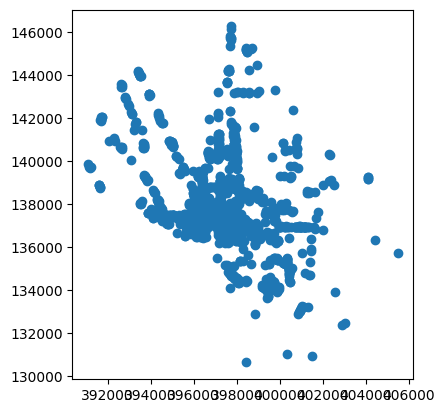

In [12]:
dc_eatery.plot()

## Density of Eateries by Census Tracts

In [13]:
# Calculate the area of each census tract in D.C.
dc_ct_eatery = dc_ct_eatery.assign(area_km2 = dc_ct_eatery.geometry.area/1e6)

In [14]:
# Create the column 'eatery_density' in 'dc_ct_eatery'
dc_ct_eatery = dc_ct_eatery.assign(eatery_density = dc_ct_eatery.eatery_count/dc_ct_eatery.area_km2)

## Visualization

In [19]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)

# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m  # If you're using a Jupyter notebook, this will display the map inline.


# Hotspot Analysis in D.C.
* Data source: https://opendata.dc.gov/datasets/DCGIS::crime-incidents-in-the-last-30-days/about

## Read Data and Process Data [Recap]

In [20]:
# read crime incidents in D.C.
dc_crime = gpd.read_file("https://opendata.dc.gov/datasets/DCGIS::crime-incidents-in-the-last-30-days.geojson")

In [21]:
dc_crime.head()


CCN                REPORT_DAT     SHIFT  METHOD              OFFENSE  \
0  23169311 2023-10-14 04:24:51+00:00  MIDNIGHT  OTHERS          THEFT/OTHER   
1  23169743 2023-10-15 00:50:52+00:00   EVENING  OTHERS  MOTOR VEHICLE THEFT   
2  23170014 2023-10-15 17:10:54+00:00       DAY  OTHERS             BURGLARY   
3  23170071 2023-10-15 18:31:51+00:00       DAY  OTHERS  MOTOR VEHICLE THEFT   
4  23170428 2023-10-17 12:38:15+00:00       DAY  OTHERS         THEFT F/AUTO   

                                     BLOCK         XBLOCK         YBLOCK WARD  \
0         1400 - 1499 BLOCK OF P STREET NW  397115.780000  137977.230000    2   
1  1200 - 1399 BLOCK OF DELAWARE AVENUE SW  398747.163005  134091.609114    6   
2       3300 - 3399 BLOCK OF 10TH PLACE SE  400691.930815  130446.779478    8   
3        EADS STREET NE AND 56TH STREET NE  406895.400004  136442.770012    7   
4   735 - 939 BLOCK OF JEFFERSON STREET NE  400604.220000  143160.870000    5   

  ANC  ... CENSUS_TRACT VOTING_PRECINCT   LATITUDE  LONGITUDE   BID  \
0  2F  ...       005203     Precinct 16  38.909652 -77.033254  None   
1  6D  ...       006400    Precinct 127  38.874652 -77.014438  None   
2  8C  ...       007304    Precinct 120  38.841819 -76.992030  None   
3  7C  ...       007807     Precinct 95  38.895806 -76.920513  None   
4  5A  ...       009508     Precinct 66  38.956352 -76.993029  None   

                 START_DATE                  END_DATE   OBJECTID  \
0 2023-10-14 03:13:00+00:00 2023-10-14 03:15:00+00:00  427423372   
1 2023-10-14 16:00:00+00:00 2023-10-14 23:40:00+00:00  427423373   
2 2023-10-15 15:20:00+00:00                       NaT  427423374   
3 2023-10-15 17:40:00+00:00                       NaT  427423375   
4 2023-10-11 23:00:00+00:00 2023-10-12 14:00:00+00:00  427423376   

  OCTO_RECORD_ID                    geometry  
0           None  POINT (-77.03326 38.90966)  
1           None  POINT (-77.01444 38.87466)  
2           None  POINT (-76.99203 38.84183)  
3           None  POINT (-76.92052 38.89581)  
4           None  POINT (-76.99303 38.95636)  

[5 rows x 24 columns]

In [22]:
# Reproject the `dc_crime` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_crime_rprj = dc_crime.to_crs(dc_census_tract_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_ct_crime = gpd.sjoin(dc_crime_rprj, dc_census_tract_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_ct_crime = dc_ct_crime.assign(crime_count = np.ones(dc_ct_crime.shape[0]))
dc_ct_crime = dc_ct_crime.groupby('GEOID')['crime_count'].sum().reset_index()

# Merge the crime counts with the census tracts GeoDataFrame
dc_ct_crime = dc_census_tract_rprj.merge(dc_ct_crime, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without crime incidents
dc_ct_crime['crime_count'] = dc_ct_crime['crime_count'].fillna(0)


In [23]:
dc_ct_crime.head()

STATEFP COUNTYFP TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      11      001  004001  11001004001  40.01  Census Tract 40.01  G5020   
1      11      001  004002  11001004002  40.02  Census Tract 40.02  G5020   
2      11      001  003600  11001003600     36     Census Tract 36  G5020   
3      11      001  004201  11001004201  42.01  Census Tract 42.01  G5020   
4      11      001  004202  11001004202  42.02  Census Tract 42.02  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  271037    2414  +38.9208738  -077.0462674   
1        S  194755       0  +38.9181186  -077.0437209   
2        S  305616       0  +38.9236744  -077.0296273   
3        S  204529       0  +38.9162076  -077.0388456   
4        S  207646       0  +38.9134023  -077.0430254   

                                            geometry  crime_count  
0  POLYGON ((395648.402 139264.423, 395659.339 13...          5.0  
1  POLYGON ((395984.938 138716.974, 395984.768 13...         13.0  
2  POLYGON ((397189.939 139855.623, 397210.581 13...         37.0  
3  POLYGON ((396386.882 138479.777, 396387.002 13...         13.0  
4  POLYGON ((396011.287 138515.924, 396033.150 13...         17.0

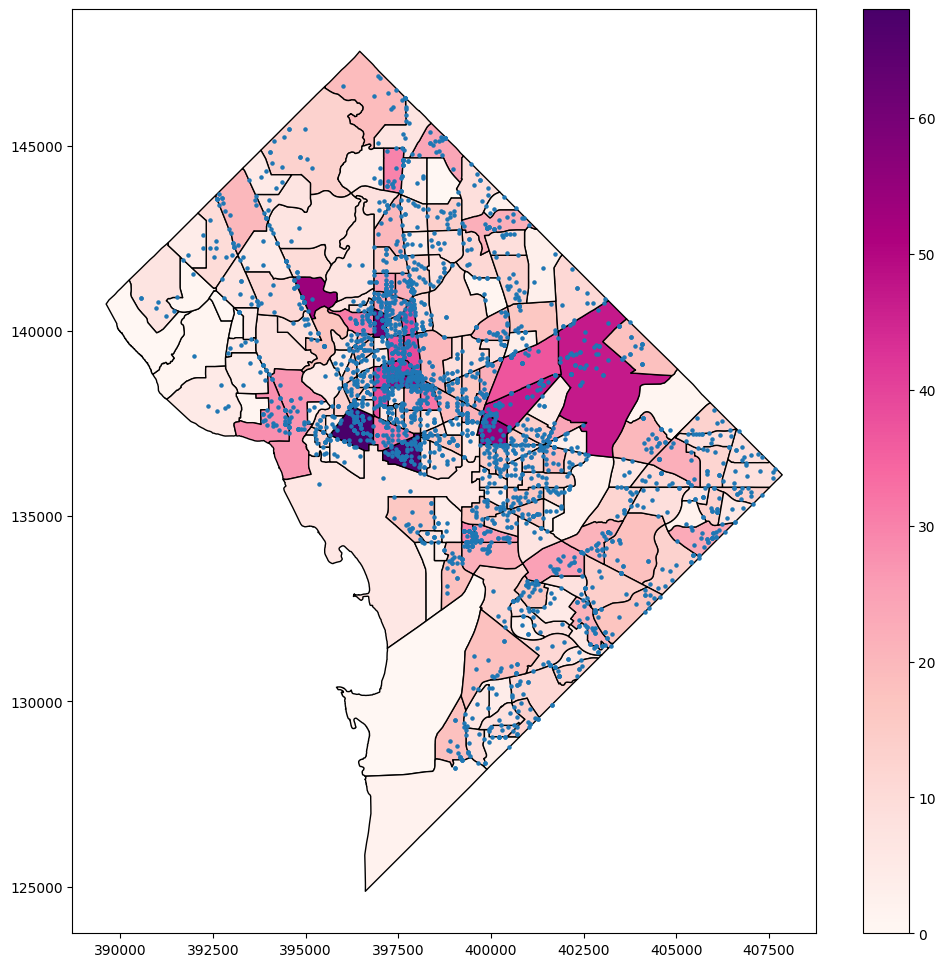

In [24]:
fig, ax = plt.subplots(figsize=(12,12))

# Plot the census tracts with color based on 'eatery_count'
dc_ct_crime.plot(ax=ax, column='crime_count', legend=True, cmap='RdPu', linewidth=1, edgecolor='black')

# Plot the crime incidents
dc_crime_rprj.plot(ax=ax, marker='o', markersize=5, legend=True)

# Show the plot
plt.show()

## Spatial Autocorrelation -- Crime Incidents across CENSUS TRACTS in D.C.

In [25]:
# Create spatial weights matrix
w = libpysal.weights.Queen.from_dataframe(dc_ct_crime)


In [26]:
# Moran's I
moran = esda.moran.Moran(dc_ct_crime["crime_count"], w)


In [27]:
print("Moran's I:", moran.I)


Moran's I: 0.1637667176711549


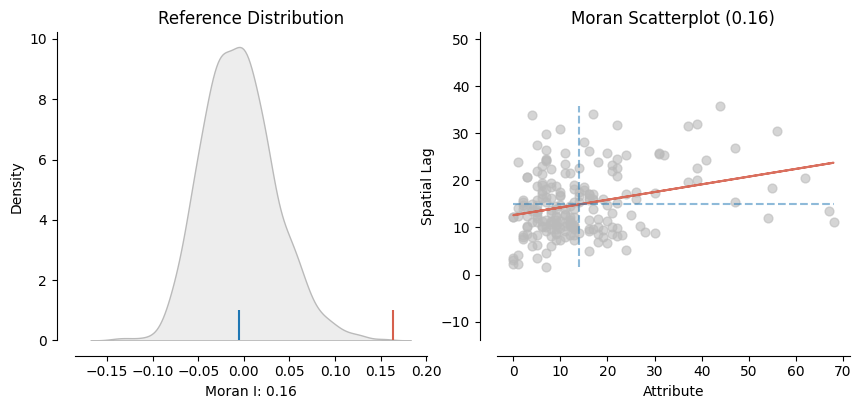

In [28]:
# Moran's scatterplot
esdaplot.plot_moran(moran, dc_ct_crime);


In [29]:
# Local Moran's I
local_moran = esda.moran.Moran_Local(dc_ct_crime["crime_count"], w)


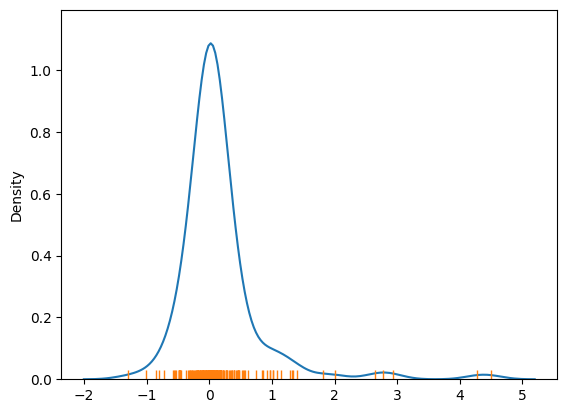

In [30]:
# plotting Local Moran's I
ax = sns.kdeplot(local_moran.Is)
sns.rugplot(local_moran.Is, ax=ax);

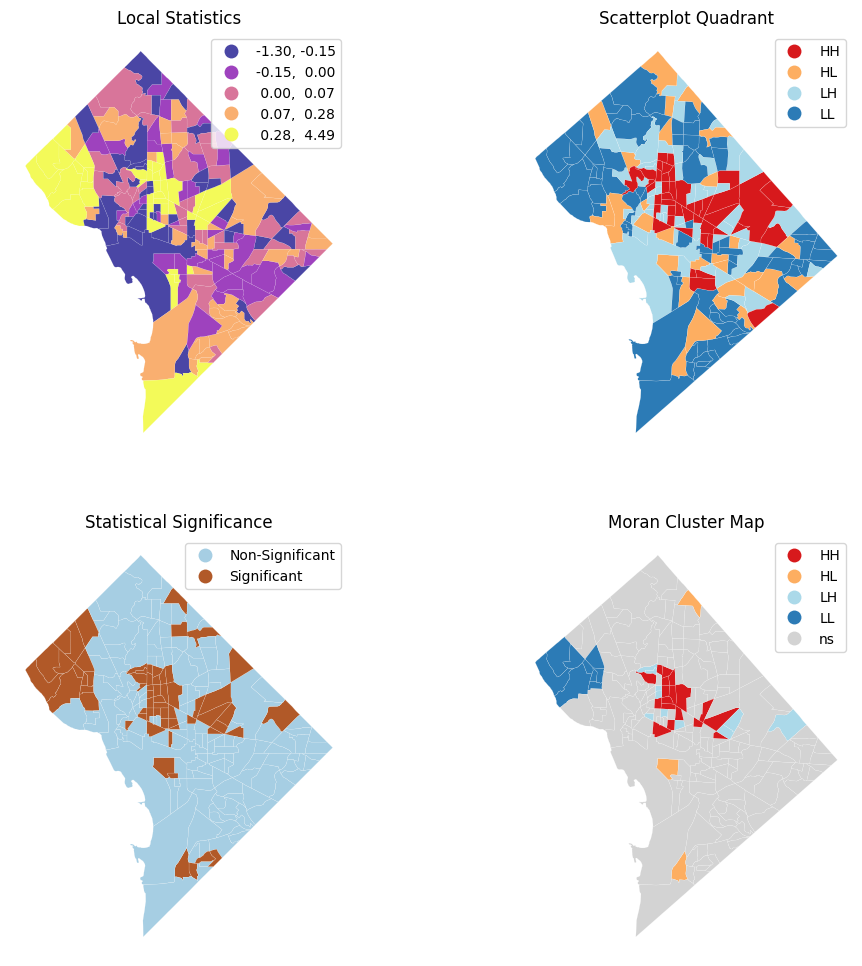

In [31]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# Subplot 1: Choropleth of local statistics
ax = axs[0]
dc_ct_crime.assign(Is=local_moran.Is).plot(column="Is", cmap="plasma", scheme="quantiles", k=5, edgecolor="white", linewidth=0.1, alpha=0.75, legend=True, ax=ax)

# Subplot 2: Quadrant categories
ax = axs[1]
esdaplot.lisa_cluster(local_moran, dc_ct_crime.to_crs(26986), p=1, ax=ax)

# Subplot 3: Significance map (alpha=0.10)
ax = axs[2]
labels = pd.Series(1 * (local_moran.p_sim < 0.10), index=dc_ct_crime.index).map({1: "Significant", 0: "Non-Significant"})
dc_ct_crime.assign(cl=labels).plot(column="cl", categorical=True, k=2, cmap="Paired", linewidth=0.1, edgecolor="white", legend=True, ax=ax)

# Subplot 4: Cluster map
ax = axs[3]
esdaplot.lisa_cluster(local_moran, dc_ct_crime.to_crs(26986), p=0.05, ax=ax)

# Figure styling #
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(["Local Statistics","Scatterplot Quadrant","Statistical Significance","Moran Cluster Map"][i]);

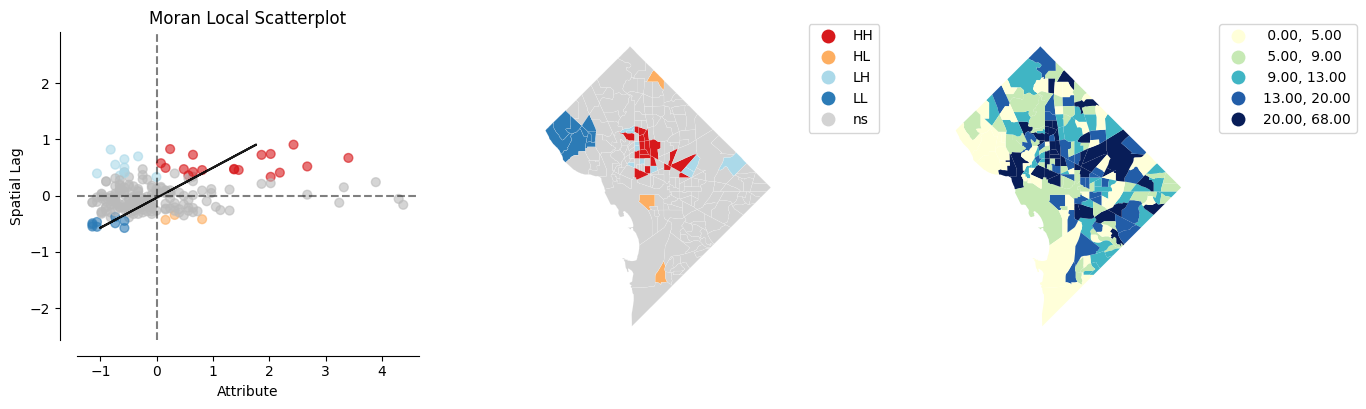

In [32]:
# plot the Moran plot (showing significant clusters and outliers) next to the resulting Moran Cluster Map.
esdaplot.plot_local_autocorrelation(local_moran, dc_ct_crime, 'crime_count', p=0.05);


In [33]:
# detecting clusters and outliers
dc_ct_crime[['GEOID', 'crime_count', 'geometry']].head()


GEOID  crime_count                                           geometry
0  11001004001          5.0  POLYGON ((395648.402 139264.423, 395659.339 13...
1  11001004002         13.0  POLYGON ((395984.938 138716.974, 395984.768 13...
2  11001003600         37.0  POLYGON ((397189.939 139855.623, 397210.581 13...
3  11001004201         13.0  POLYGON ((396386.882 138479.777, 396387.002 13...
4  11001004202         17.0  POLYGON ((396011.287 138515.924, 396033.150 13...

In [34]:
# Calculate the local Moran's I statistics and assign them along with their associated p-values and quadrants to each zone
local_moran = esda.moran.Moran_Local(dc_ct_crime['crime_count'], w)
dc_ct_crime['local_moran_i'] = local_moran.Is
dc_ct_crime['local_moran_p_value'] = local_moran.p_sim
dc_ct_crime['local_moran_quadrant'] = local_moran.q

In [35]:
# Get the statistically significant clusters and outliers at alpha = 0.10
alpha = 0.10
hotspots = dc_ct_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = dc_ct_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = dc_ct_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = dc_ct_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")
not_significant = dc_ct_crime.query(f"local_moran_p_value >= {alpha}")

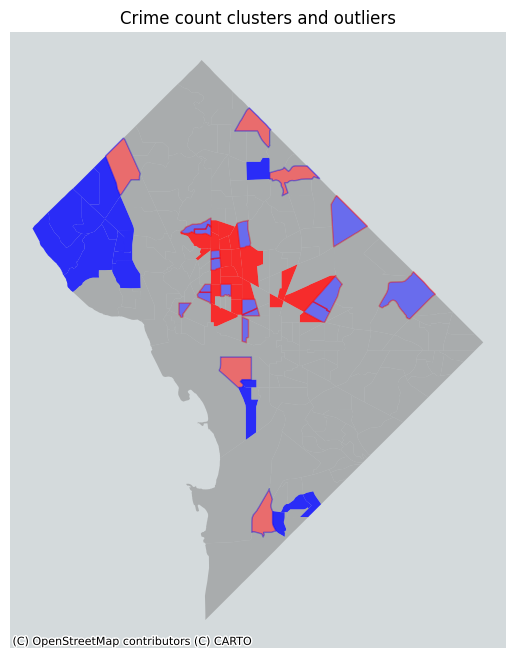

In [36]:
# Plot the hot spots, cold spots, diamonds and doughnuts.
fig, ax = plt.subplots(figsize=(16,8))
hotspots.plot(color='red',alpha=0.8, ax=ax, label='Hot Spot')
coldspots.plot(color='blue', alpha=0.8, ax=ax, label='Cold Spot')
diamonds.plot(color='red', edgecolor='blue', alpha=0.5, ax=ax, label='Diamonds')
doughnuts.plot(color='blue', edgecolor='red', alpha=0.5, ax=ax, label='Doughnuts')
not_significant.plot(color='gray', alpha=0.5, label='Not Significant', ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=26986)
ax.set_title('Crime count clusters and outliers')
ax.axis('off');

## Exercise: Spatial Autocorrelation -- Crime Incidents across CENSUS BLOCKS in D.C.

In [37]:
# Read census block data
dc_census_block = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/BG/tl_2020_11_bg.zip")

In [38]:
dc_census_block_rprj = dc_census_block.to_crs("EPSG:6487")

In [39]:
# Reproject the `dc_crime` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_crime_rprj = dc_crime.to_crs(dc_census_block_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_cb_crime = gpd.sjoin(dc_crime_rprj, dc_census_block_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_cb_crime = dc_cb_crime.assign(crime_count = np.ones(dc_cb_crime.shape[0]))
dc_cb_crime = dc_cb_crime.groupby('GEOID')['crime_count'].sum().reset_index()

# Merge the crime counts with the census tracts GeoDataFrame
dc_cb_crime = dc_census_block_rprj.merge(dc_cb_crime, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without crime incidents
dc_cb_crime['crime_count'] = dc_cb_crime['crime_count'].fillna(0)


In [40]:
dc_cb_crime.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      11      001  010800        1  110010108001  Block Group 1  G5030   
1      11      001  010900        2  110010109002  Block Group 2  G5030   
2      11      001  007401        1  110010074011  Block Group 1  G5030   
3      11      001  007403        1  110010074031  Block Group 1  G5030   
4      11      001  007404        1  110010074041  Block Group 1  G5030   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S   112810        0  +38.9005669  -077.0474728   
1        S  2270174  2933566  +38.8132364  -077.0238475   
2        S  1029053   200980  +38.8668098  -076.9949201   
3        S   126738        0  +38.8481009  -076.9774095   
4        S   360630        0  +38.8514546  -076.9784997   

                                            geometry  crime_count  
0  POLYGON ((395651.030 136943.350, 395651.295 13...          0.0  
1  POLYGON ((396595.679 125860.383, 396600.993 12...          2.0  
2  POLYGON ((399531.639 133441.098, 399703.649 13...          9.0  
3  POLYGON ((401625.668 130979.555, 401651.014 13...          4.0  
4  POLYGON ((401446.271 131728.707, 401496.003 13...          1.0

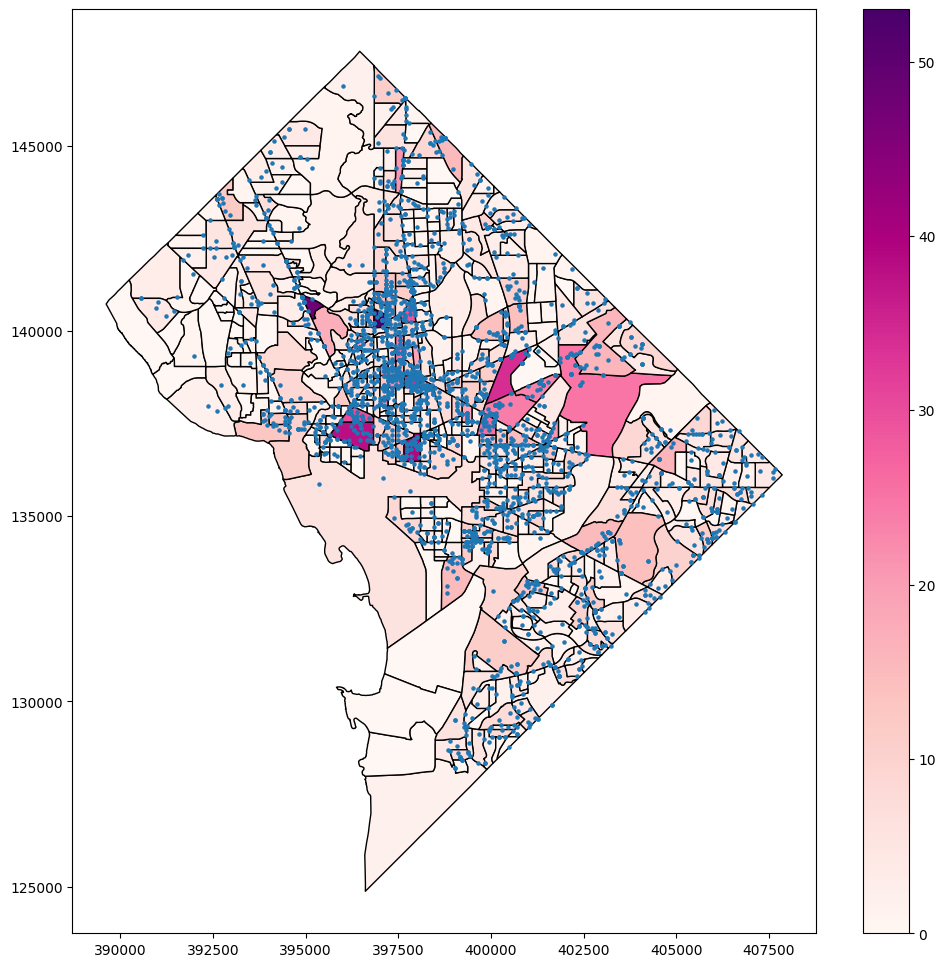

In [41]:
fig, ax = plt.subplots(figsize=(12,12))

# Plot the census tracts with color based on 'eatery_count'
dc_cb_crime.plot(ax=ax, column='crime_count', legend=True, cmap='RdPu', linewidth=1, edgecolor='black')

# Plot the crime incidents
dc_crime_rprj.plot(ax=ax, marker='o', markersize=5, legend=True)

# Show the plot
plt.show()

Spatial Autocorrelation -- Eateries across census tracts in DC

In [42]:
# Create spatial weights matrix
w = libpysal.weights.Queen.from_dataframe(dc_cb_crime)


In [43]:
# Moran's I
moran = esda.moran.Moran(dc_cb_crime["crime_count"], w)


In [44]:
print("Moran's I:", moran.I)


Moran's I: 0.16847580786977695


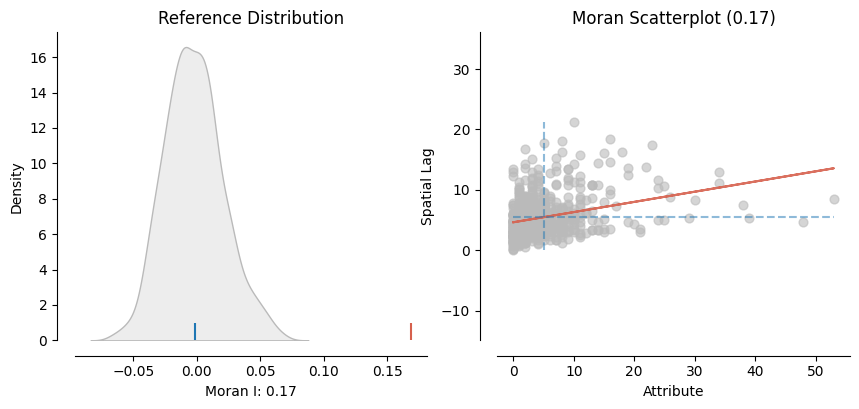

In [45]:
# Moran's scatterplot
esdaplot.plot_moran(moran, dc_cb_crime);


In [46]:
# Local Moran's I
local_moran = esda.moran.Moran_Local(dc_cb_crime["crime_count"], w)


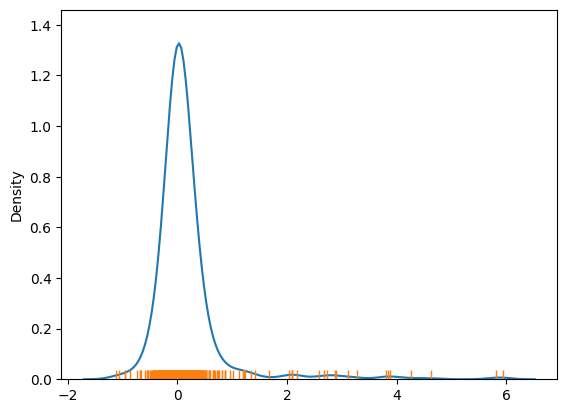

In [47]:
# plotting Local Moran's I
ax = sns.kdeplot(local_moran.Is)
sns.rugplot(local_moran.Is, ax=ax);

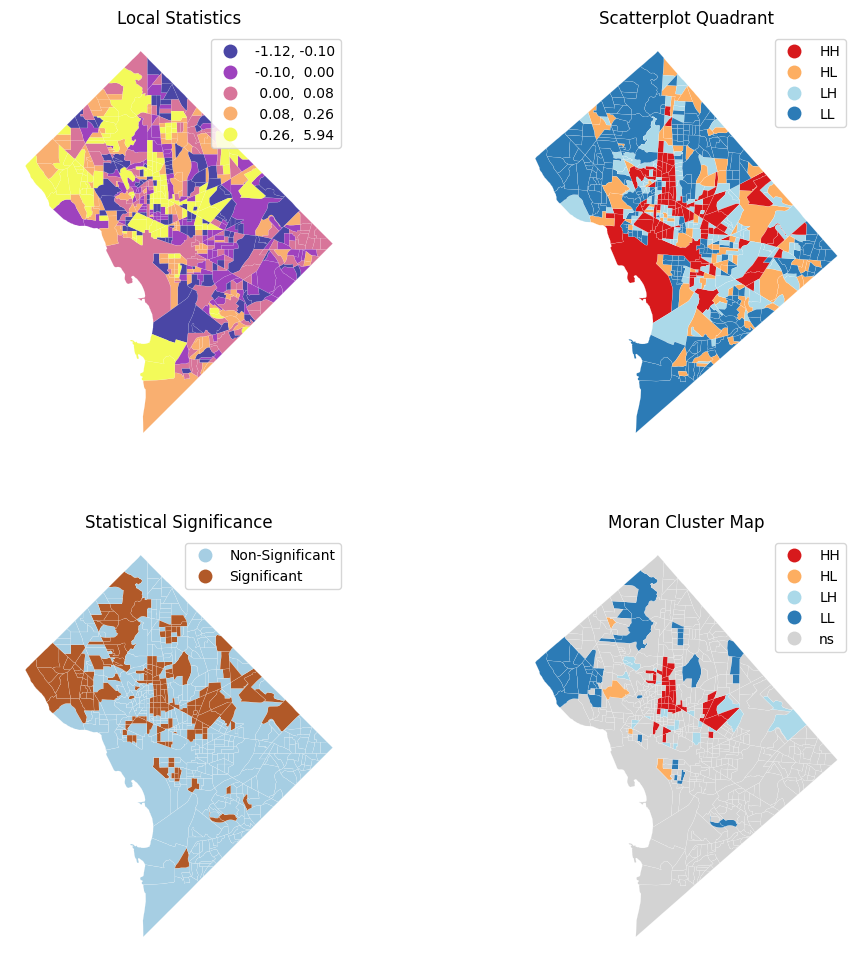

In [48]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# Subplot 1: Choropleth of local statistics
ax = axs[0]
dc_cb_crime.assign(Is=local_moran.Is).plot(column="Is", cmap="plasma", scheme="quantiles", k=5, edgecolor="white", linewidth=0.1, alpha=0.75, legend=True, ax=ax)

# Subplot 2: Quadrant categories
ax = axs[1]
esdaplot.lisa_cluster(local_moran, dc_cb_crime.to_crs(26986), p=1, ax=ax)

# Subplot 3: Significance map (alpha=0.10)
ax = axs[2]
labels = pd.Series(1 * (local_moran.p_sim < 0.10), index=dc_cb_crime.index).map({1: "Significant", 0: "Non-Significant"})
dc_cb_crime.assign(cl=labels).plot(column="cl", categorical=True, k=2, cmap="Paired", linewidth=0.1, edgecolor="white", legend=True, ax=ax)

# Subplot 4: Cluster map
ax = axs[3]
esdaplot.lisa_cluster(local_moran, dc_cb_crime.to_crs(26986), p=0.05, ax=ax)

# Figure styling #
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(["Local Statistics","Scatterplot Quadrant","Statistical Significance","Moran Cluster Map"][i]);

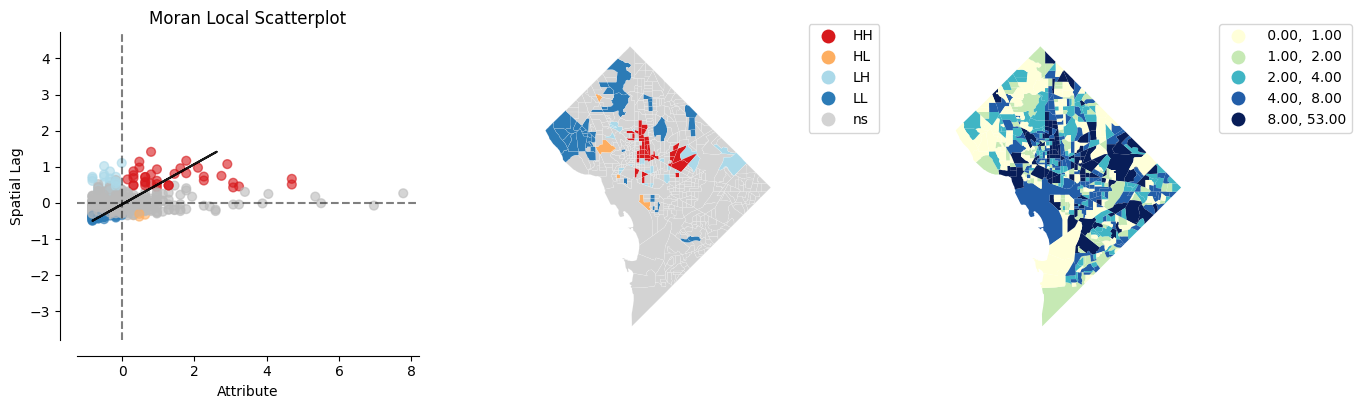

In [49]:
# plot the Moran plot (showing significant clusters and outliers) next to the resulting Moran Cluster Map.
esdaplot.plot_local_autocorrelation(local_moran, dc_cb_crime, 'crime_count', p=0.05);


In [50]:
# detecting clusters and outliers
dc_cb_crime[['GEOID', 'crime_count', 'geometry']].head()


GEOID  crime_count  \
0  110010108001          0.0   
1  110010109002          2.0   
2  110010074011          9.0   
3  110010074031          4.0   
4  110010074041          1.0   

                                            geometry  
0  POLYGON ((395651.030 136943.350, 395651.295 13...  
1  POLYGON ((396595.679 125860.383, 396600.993 12...  
2  POLYGON ((399531.639 133441.098, 399703.649 13...  
3  POLYGON ((401625.668 130979.555, 401651.014 13...  
4  POLYGON ((401446.271 131728.707, 401496.003 13...

In [51]:
# Calculate the local Moran's I statistics and assign them along with their associated p-values and quadrants to each zone
local_moran = esda.moran.Moran_Local(dc_cb_crime['crime_count'], w)
dc_cb_crime['local_moran_i'] = local_moran.Is
dc_cb_crime['local_moran_p_value'] = local_moran.p_sim
dc_cb_crime['local_moran_quadrant'] = local_moran.q

In [52]:
# Get the statistically significant clusters and outliers at alpha = 0.10
alpha = 0.10
hotspots = dc_cb_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = dc_cb_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = dc_cb_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = dc_cb_crime.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")
not_significant = dc_cb_crime.query(f"local_moran_p_value >= {alpha}")

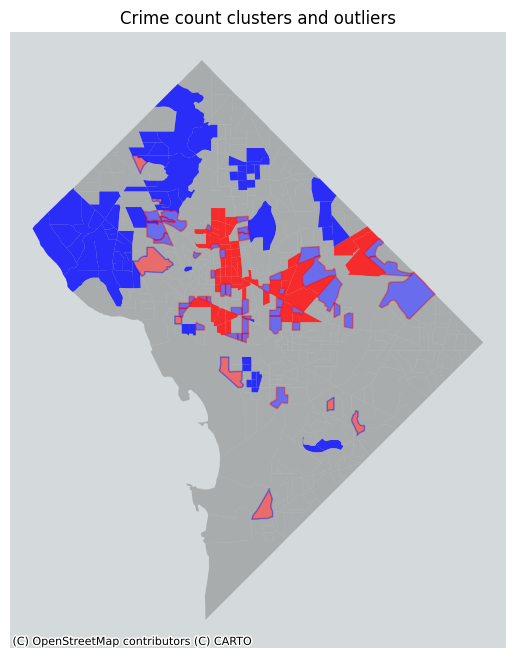

In [53]:
# Plot the hot spots, cold spots, diamonds and doughnuts.
fig, ax = plt.subplots(figsize=(16,8))
hotspots.plot(color='red',alpha=0.8, ax=ax, label='Hot Spot')
coldspots.plot(color='blue', alpha=0.8, ax=ax, label='Cold Spot')
diamonds.plot(color='red', edgecolor='blue', alpha=0.5, ax=ax, label='Diamonds')
doughnuts.plot(color='blue', edgecolor='red', alpha=0.5, ax=ax, label='Doughnuts')
not_significant.plot(color='gray', alpha=0.5, label='Not Significant', ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=26986)
ax.set_title('Crime count clusters and outliers')
ax.axis('off');

# 3. Walksheds of Metro Staions in D.C.

## Retrieve Metro Stations Data
* Data Source: https://opendata.dc.gov/datasets/DCGIS::metro-stations-in-dc/about
* Walkshed radius: https://www.mwcog.org/newsroom/2019/07/16/walksheds-show-planners-how-easily-people-can-walk-to-transit/

In [54]:
dc_station_url = "https://opendata.dc.gov/datasets/DCGIS::metro-stations-in-dc.geojson"

# Read the data into a GeoDataFrame
dc_station_gdf = gpd.read_file(dc_station_url)

# Reproject
dc_station_gdf_rprj = dc_station_gdf.to_crs(dc_census_tract_rprj.crs)

# Remove the stations outside the boundary of D.C.
dc_station_gdf_rprj = gpd.clip(dc_station_gdf_rprj, dc_census_tract_rprj)

# Errors will show after running. It would no affect the results.

<Axes: >

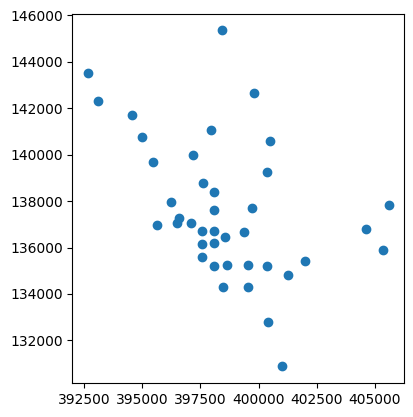

In [55]:
dc_station_gdf_rprj.plot()

## Create Walksheds Using Simple Buffer

In [56]:
# Set Buffer Raidus
buffer_distance = 804.67 # Half a mile is 804.67 metres.

# Create the buffer around each point to get a GeoSeries of buffered geometries
walksheds_simple_buffer = dc_station_gdf_rprj.geometry.buffer(buffer_distance)

# Create a new GeoDataFrame from the buffered geometries
walkshed_sb_gdf = gpd.GeoDataFrame(geometry=walksheds_simple_buffer)

# If you want to retain the original data from 'dc_station_gdf_rprj', you can join it with the new GeoDataFrame
walkshed_sb_gdf = walkshed_sb_gdf.join(dc_station_gdf_rprj.drop(columns='geometry'))

<Axes: >

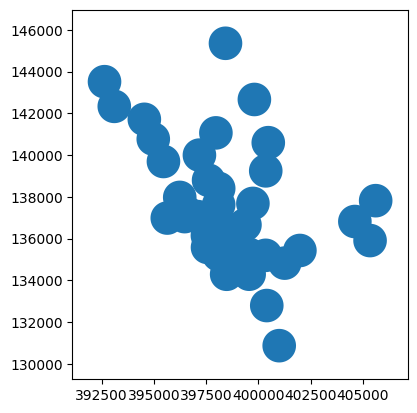

In [57]:
walkshed_sb_gdf.plot()

### Q1: How many eateries in each walkshed?

In [58]:
dc_walkshed_sb_eatery = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_sb_gdf, predicate='within', how='inner').reset_index(drop = True)
dc_walkshed_sb_eatery = dc_walkshed_sb_eatery.assign(eatery_count = np.ones(dc_walkshed_sb_eatery.shape[0]))
dc_walkshed_sb_eatery = dc_walkshed_sb_eatery.groupby('GIS_ID')['eatery_count'].sum().reset_index()

# Merge the eatery counts with the walkshed GeoDataFrame
dc_walkshed_sb_eatery = walkshed_sb_gdf.merge(dc_walkshed_sb_eatery, on='GIS_ID', how='left')

# Replace NaN values with 0 for walkshed without eatery
dc_walkshed_sb_eatery['eatery_count'] = dc_walkshed_sb_eatery['eatery_count'].fillna(0)

#### Visualization

In [59]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)
dc_walkshed_sb_eatery_geog = dc_walkshed_sb_eatery.to_crs(dc_census_tract.crs)

# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Add the walksheds to the map
folium.Choropleth(
    geo_data=dc_walkshed_sb_eatery_geog.to_json(),
    name='Walkshed with Simple Buffer',
    data=dc_walkshed_sb_eatery_geog,
    columns=['GIS_ID', 'eatery_count'],
    key_on='feature.properties.GIS_ID',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Counts by Walksheds'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m  # If you're using a Jupyter notebook, this will display the map inline.


### Q2: Which eatery is located within the highest number of station walksheds?

In [60]:
# Perform the spatial join
joined_gdf = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_sb_gdf, predicate='within', how='left').reset_index(drop = True)

# Count the number of walksheds each eatery is within
eatery_walkshed_counts = joined_gdf.groupby('UID').size()

# Find the eatery with the highest count
most_walksheds = eatery_walkshed_counts.idxmax()
highest_count = eatery_walkshed_counts.max()

# Get the details of the eatery with the most walksheds
eatery_with_most_walksheds = dc_eatery_gdf_rprj.loc[dc_eatery_gdf_rprj['UID'] == most_walksheds]

print(f"The eatery with the most walksheds is: {(eatery_with_most_walksheds.Name.values)}")
print(f"Number of walksheds: {highest_count}")


The eatery with the most walksheds is: ['Oya Restaurant & Lounge']
Number of walksheds: 6


## Create Walksheds With Road Network

* The cell below would take no more than 7 mins to finish.

In [61]:
# Define the walking distance in meters
walking_distance_metres = 804.67 # Half a mile is 804.67 metres.
alpha = 300

# Initialize an empty list to hold the walkshed polygons
walkshed_as = []

# Loop through each station to calculate walksheds
# It would take no more than 5 mins
for index, station in dc_station_gdf.iterrows():
    # Get the x and y coordinates of the station
    x, y = station.geometry.x, station.geometry.y

    # Create the network graph around the station
    G = ox.graph_from_point((y, x), dist=walking_distance_metres, dist_type='network', network_type='walk')

    # Find the node in the graph that's closest to the station
    G_proj = ox.project_graph(G)
    center_node = ox.distance.nearest_nodes(G_proj, x, y)

    # Create a subgraph within the walking distance
    subgraph = nx.ego_graph(G_proj, center_node, radius=walking_distance_metres, distance='length')

    # Use the nodes from the subgraph to create an alphashape polygon
    node_points = [(data["lon"], data["lat"]) for node, data in subgraph.nodes(data=True)]
    if len(node_points) > 3:  # alphashape requires at least 4 points to compute a shape
        alpha_shape = alphashape(node_points, alpha=alpha)
        walkshed_as.append(gpd.GeoDataFrame([[station['GIS_ID'], alpha_shape]], columns=['GIS_ID', 'geometry']))

# Combine all walkshed polygons into a single GeoDataFrame
walkshed_as_gdf = gpd.GeoDataFrame(pd.concat(walkshed_as, ignore_index=True)).set_crs("EPSG:4326")

KeyboardInterrupt: 

In [ ]:
walkshed_as_gdf.plot()

### Exercie 1: How many eateries in each walkshed?

In [ ]:
walkshed_as_gdf_rprj = walkshed_as_gdf.to_crs(dc_census_tract_rprj.crs)
dc_walkshed_as_eatery = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_as_gdf_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_walkshed_as_eatery = dc_walkshed_as_eatery.assign(eatery_count = np.ones(dc_walkshed_as_eatery.shape[0]))
dc_walkshed_as_eatery = dc_walkshed_as_eatery.groupby('GIS_ID')['eatery_count'].sum().reset_index()

# Merge the eatery counts with the walkshed GeoDataFrame
dc_walkshed_as_eatery = walkshed_as_gdf.merge(dc_walkshed_as_eatery, on='GIS_ID', how='left')

# Replace NaN values with 0 for walkshed without eatery
dc_walkshed_as_eatery['station_count'] = dc_walkshed_as_eatery['eatery_count'].fillna(0)

#### Visualization

In [ ]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)
dc_walkshed_as_eatery_geog = dc_walkshed_as_eatery.to_crs(dc_census_tract.crs)
# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Add the walksheds to the map
folium.Choropleth(
    geo_data=dc_walkshed_as_eatery_geog.to_json(),
    name='Walkshed with alphashape',
    data=dc_walkshed_as_eatery_geog,
    columns=['GIS_ID', 'eatery_count'],
    key_on='feature.properties.GIS_ID',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Counts by Walksheds'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m  # If you're using a Jupyter notebook, this will display the map inline.


### Exercise 2: Which eatery is located within the highest number of station walkshed?

In [ ]:
# Perform the spatial join
joined_gdf = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_as_gdf_rprj, predicate='within', how='left').reset_index(drop = True)

# Count the number of walksheds each eatery is within
eatery_walkshed_counts = joined_gdf.groupby('UID').size()  # Replace 'eatery_id' with the appropriate identifier for eateries

# Find the eatery with the highest count
most_walksheds = eatery_walkshed_counts.idxmax()
highest_count = eatery_walkshed_counts.max()

# Get the details of the eatery with the most walksheds
eatery_with_most_walksheds = dc_eatery_gdf_rprj.loc[dc_eatery_gdf_rprj['UID'] == most_walksheds]

print(f"The eatery with the most walksheds is: {(eatery_with_most_walksheds.Name.values)}")
print(f"Number of walksheds: {highest_count}")


# NDVI of Walksheds

## Reading Rasters with Rasterio

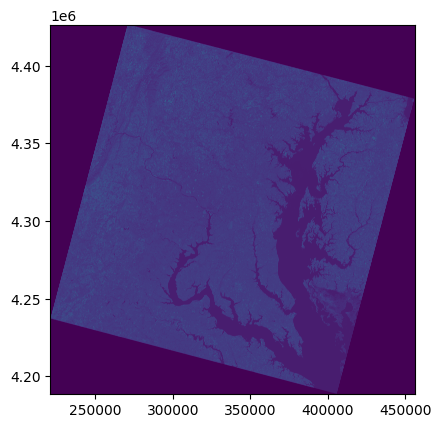

In [65]:
# plot one band (Near Infrared)
# link to get the raster data:
# nirband = "https://www.dropbox.com/scl/fi/jhlov245pautfmkggieop/LC09_L1TP_015033_20231103_20231103_02_T1_B5.TIF?rlkey=5ympdgn2bxnngsy4ke212xm7x&dl=1"

# open the raster with rasterio and plot
nirband_raster = rasterio.open('LC09_L1TP_015033_20231103_20231103_02_T1_B5.tiff')
show((nirband_raster, 1));

## Plot True Color Raster

In [67]:
# read in multiple bands
# It would take no more than 2 mins.

# You can also get the data from these links.
# redband = "https://www.dropbox.com/scl/fi/riufhhwfd6ioqboe2ai4i/LC09_L1TP_015033_20231103_20231103_02_T1_B4.TIF?rlkey=ha19z35sk964jzqrvmfvfzl5u&dl=1"
# grnband = "https://www.dropbox.com/scl/fi/a7vt3vi7hqzlaqy0v9f8b/LC09_L1TP_015033_20231103_20231103_02_T1_B3.TIF?rlkey=rnihwnu3mjg055qy8o4h9tq5z&dl=1"
# bluband = "https://www.dropbox.com/scl/fi/noh7796lb0utx1b9lnime/LC09_L1TP_015033_20231103_20231103_02_T1_B2.TIF?rlkey=bze1j8quwq61vny9n6to48sx4&dl=1"

redband = "LC09_L1TP_015033_20231103_20231103_02_T1_B4.TIF"
grnband = "LC09_L1TP_015033_20231103_20231103_02_T1_B3.TIF"
bluband = "LC09_L1TP_015033_20231103_20231103_02_T1_B2.TIF"

with rasterio.open(nirband) as src:
  nir = src.read(1)

with rasterio.open(redband) as src:
  red = src.read(1)

with rasterio.open(grnband) as src:
  grn = src.read(1)

with rasterio.open(bluband) as src:
  blu = src.read(1)

RasterioIOError: LC09_L1TP_015033_20231103_20231103_02_T1_B5.TIF: No such file or directory

In [ ]:
# Function to normalize the grid values
def normalize(band):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))


In [ ]:
# Normalize the bands
redn = normalize(red)
grnn = normalize(grn)
blun = normalize(blu)
nirn = normalize(nir)

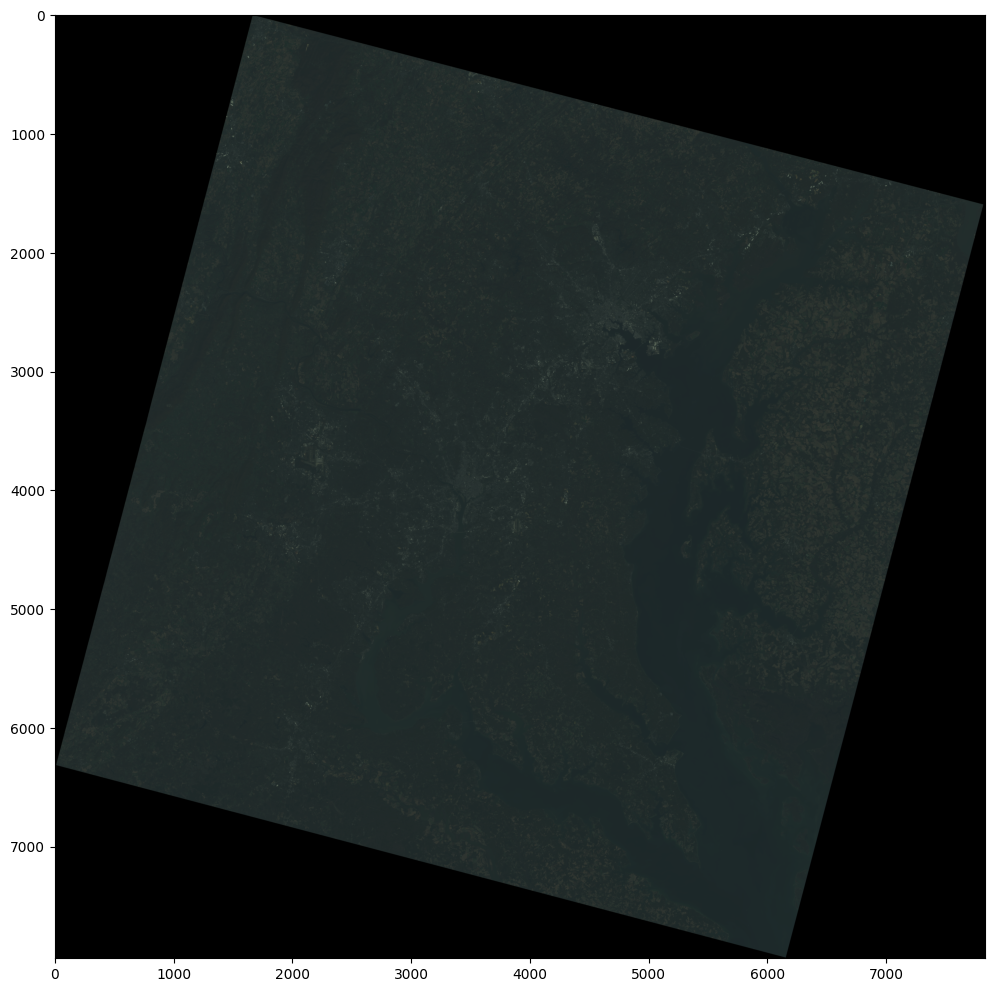

In [ ]:
# Create RGB natural color composite
rgb = np.dstack((redn, grnn, blun))

# Plot the composite RGB image
plt.figure(figsize=(12,17))
plt.imshow(rgb, vmin=0, vmax=1)

## Plot NDVI

The Normalized Difference Vegetation Index (NDVI) is an idex that uses an image's Near-Infrared and Red bands to highlight the amount of "greenness" in an image

In [ ]:
# create the NDVI function
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype(float)
    red = red.astype(float)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [ ]:
# calculate the ndvi
ndvi = calc_ndvi(nirn,redn)

<ipython-input-70-2f99c67ba06b>:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0, 0.5, 'Row #')

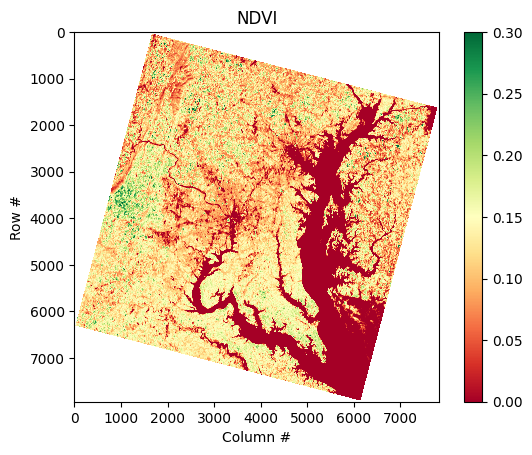

In [ ]:
plt.imshow(ndvi, cmap='RdYlGn',vmin=0,vmax=.3)
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')

## Zonal Statistics

We can get the average raster cell values for a set of vectors (polygons)

In [ ]:
# define the top left corner (raster origin) and cell size
transform=rasterio.transform.from_origin(221085.0, 4426515.0, 30.0, 30.0 )

# define the coordinate system (UTM zone 18)
crs = rasterio.crs.CRS.from_epsg(32618)

# convert the NDVI matrix back into a raster (so that we can get the correct coordinate information)
with rasterio.open('MD_DC_VA.tif', 'w', driver='GTiff',
                   height=ndvi.shape[0], width=ndvi.shape[1],
                   count=1, dtype=ndvi.dtype,
                   crs= crs,
                   transform=transform ) as output:
    output.write(ndvi,1)
    output.close()

In [ ]:
# read the ndvi raster back in
ndvi_raster =rasterio.open('MD_DC_VA.tif')

In [ ]:
# project the walksheds (calculated by alphashape) to the same coordinate system as the raster
walksheds_ndvi = walkshed_as_gdf.to_crs(epsg=32618)

<Axes: >

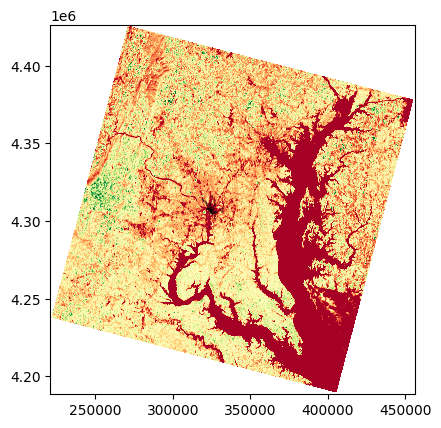

In [ ]:
# plot both the ndvi raster and the walksheds
# Walkshed are in the center parts.
fig, ax = plt.subplots()
walksheds_ndvi.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)
show(ndvi_raster, cmap='RdYlGn', ax=ax, vmin=0, vmax=.3)

In [ ]:
# get the average ndvi per walkshed
avg_ndvi_per_walkshed = rstats.zonal_stats(walksheds_ndvi.geometry, 'MD_DC_VA.tif')
avg = [r['mean'] for r in avg_ndvi_per_walkshed]
walksheds_ndvi['ndvi'] = avg

/usr/local/lib/python3.10/dist-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [ ]:
# print the first few rows
walksheds_ndvi.head()

GIS_ID                                           geometry      ndvi
0  MetroStnPt_1  POLYGON ((325234.449 4316073.960, 325292.502 4...  0.025055
1  MetroStnPt_2  POLYGON ((319737.169 4313714.755, 319618.820 4...  0.017795
2  MetroStnPt_3  POLYGON ((326563.969 4313549.148, 326792.078 4...  0.007143
3  MetroStnPt_4  POLYGON ((319365.039 4312715.063, 319416.870 4...  0.037335
4  MetroStnPt_5  POLYGON ((321584.775 4312303.631, 321663.741 4...  0.060223

<Axes: >

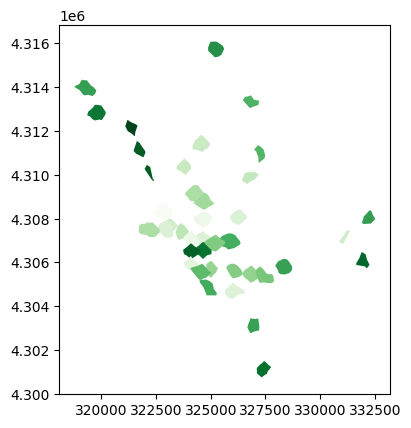

In [ ]:
# choropleth map of walksheds and ndvi
walksheds_ndvi.plot('ndvi', cmap='Greens')

# A Practical Application of Folium


## Initialize Folium

- Given a pair of latitude and longitude, folium can create a map centered around that location.

- `zoom_start` initializes the zoom level for the map. We set it to `12` for our convenience

In [ ]:
m = folium.Map(location=[38.9072, -77.0369], # Washington D.C
               zoom_start=12)

# display the map
m

## Add a Marker to the map

Using the `folium.Marker()` method.<br /> <br />It takes as parameter: <br />
    - location (where the marker is placed on the map [lat, long])<br />
    - popup (text content shown when the marker is clicked) <br />
    - icon (popup icon)
    

In [ ]:
marker = folium.Marker(
    location=[38.9072, -77.0369], # Washington D.C
    popup='The White House',
    icon=folium.Icon(color='cadetblue', icon='glyphicon-flag'),
)
marker.add_to(m)
m

We could also use the variant `folium.CircleMarker()`

In [ ]:
new_map = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='OpenStreetMap')

circle_marker = folium.CircleMarker(
    location=[38.9072, -77.0369],
    radius=12,  # Larger radius for a bigger circle
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7,
    popup='The White House'
)
circle_marker.add_to(new_map)
new_map

- It is possible to create your custom icons with a specified image and size using icons from Font Awesome or Bootstap

In [ ]:
# Assuming you're continuing from the previous map 'm'
import folium
new_map = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='OpenStreetMap')

# You would replace this with the URL of your image
icon_image_url = 'https://pic.onlinewebfonts.com/thumbnails/icons_547378.svg'  # Placeholder URL

# Create a custom icon by specifying the image URL and size
custom_icon = folium.CustomIcon(
    icon_image=icon_image_url,
    icon_size=(55, 55)  # Example size, you can adjust as needed
)

# Add a marker with the custom icon to the map
folium.Marker(
    location=[38.9072, -77.0369],
    popup='A marker with a custom icon',
    icon=custom_icon
).add_to(new_map)

# Display the map
new_map


## Add Tile Layers

- Tiles are the map's background. Different tile layers can be added for different map styles

- Some common tile styles are `'Stamen Terrain'`, `'Stamen Toner'`, `'Stamen Watercolor'`, `'CartoDB positron'`, `'CartoDB dark_matter'`


In [ ]:
new_map = folium.Map(location=[38.9072, -77.0369], zoom_start=13, tiles='OpenStreetMap')

folium.TileLayer(
    tiles='CartoDB Positron',
    attr='Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL'
).add_to(new_map)

# Add layer control to toggle tile layers
folium.LayerControl().add_to(new_map)
new_map

## Add a Chloropleth map

- Folium uses the the `folium.Chorpoleth()` method to create choropleth maps which are thematic maps where areas are shaded based on a statistical
variable

In [ ]:
# Create a map instance centered on the United States
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Get GeoJSON data for US states (this URL is just an example; you can use your own GeoJSON file)
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'
geojson_data = requests.get(geojson_url).json()

# Generate some example data (this would be your actual data)
state_data = pd.DataFrame({
    'state': [state['id'] for state in geojson_data['features']],
    'value': np.random.rand(len(geojson_data['features']))
})

print(state_data.head())

# Add the choropleth layer to the map
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=state_data,
    columns=['state', 'value'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Random Data'
).add_to(m)

# Add a layer control panel to the map
folium.LayerControl().add_to(m)

# Display the map
m


  state     value
0    AL  0.636096
1    AK  0.908825
2    AZ  0.024812
3    AR  0.498797
4    CA  0.617792


<i> Nugget <i/>  <br />

Every expert spatial data scientist takes their time to read the documentations of packages they frequently use. Its the best way to explore and familiarize yourself with the package.

[Here's the link](https://python-visualization.github.io/folium/latest/#) to Folium's documentation.

## Revisit Eatery Data


In [ ]:
dc_eatery_geog.head()

UID                   Name        Type   Latitude  Longitude  \
0   60471261          Cafe Saint Ex         bar  38.915421 -77.031701   
1  745905564  Ambassador Restaurant  restaurant  38.915983 -77.023734   
2  750467821              Bar Pilar  restaurant  38.915126 -77.031705   
3  750467824        Axum Restaurant  restaurant  38.916574 -77.024271   
4  750467826              Hawthorne         bar  38.916811 -77.031047   

                     geometry  index_right STATEFP COUNTYFP TRACTCE  \
0  POINT (-77.03170 38.91542)           39      11      001  004402   
1  POINT (-77.02373 38.91598)           39      11      001  004402   
2  POINT (-77.03170 38.91513)           39      11      001  004402   
3  POINT (-77.02427 38.91657)           39      11      001  004402   
4  POINT (-77.03105 38.91681)           39      11      001  004402   

         GEOID   NAME            NAMELSAD  MTFCC FUNCSTAT   ALAND  AWATER  \
0  11001004402  44.02  Census Tract 44.02  G5020        S  274746       0   
1  11001004402  44.02  Census Tract 44.02  G5020        S  274746       0   
2  11001004402  44.02  Census Tract 44.02  G5020        S  274746       0   
3  11001004402  44.02  Census Tract 44.02  G5020        S  274746       0   
4  11001004402  44.02  Census Tract 44.02  G5020        S  274746       0   

      INTPTLAT      INTPTLON  
0  +38.9155152  -077.0270354  
1  +38.9155152  -077.0270354  
2  +38.9155152  -077.0270354  
3  +38.9155152  -077.0270354  
4  +38.9155152  -077.0270354

Task: Pop-up window
- Define a function to create popup messages for markers. A cool feature of folium is that you can create a marker denoting each point and customize the marker as popup

- You can include as many field as you want, but here we'll use the `Name`, `Type`, `Latitude`, `Longitude` and `NAME`.

In [ ]:
def make_popup(row):
    return folium.Popup(f"""
    <b>Eatery Name:</b> {row['Name']}<br>
    <b>Eatery Type:</b> {row['Type']}<br>
    <b>Coordinates:</b> {row['Latitude'], row['Longitude']}<br>
    <b>Census Tract Code: </b> {row['NAME']}<br>
    """, max_width=250)

- Define a color mapping for permit types using folium's color mapping options

- <b> Note: <b/>
we can only use the colors available within Folium. Here's a [link to the list of colors](https://python-visualization.github.io/folium/latest/reference.html#:~:text=%5B%E2%80%98red%E2%80%99%2C%20%E2%80%98blue%E2%80%99%2C%20%E2%80%98green,gray%E2%80%99%2C%20%E2%80%98black%E2%80%99%2C%20%E2%80%98lightgray%E2%80%99%5D) available within folium

In [ ]:
color_mapping = {
    'bar': 'blue',
    'restaurant': 'green',
    'cafe': 'purple',
    'biergarten': 'orange',
    'pub': 'darkblue'
}

# Default color if permit type is not in the mapping
default_color = 'lightgray'

- Create a new map instance

- Add markers to the map, colored by eatery type

In [ ]:
m_colored_markers = folium.Map(location=[38.9072, -77.0369], zoom_start=12)

for _, row in dc_eatery_geog.iterrows():
    # Get the color for the eatery type, use default color if not found
    marker_color = color_mapping.get(row['Type'], default_color)

    # Add marker to the map
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=make_popup(row),
        icon=folium.Icon(color=marker_color)
    ).add_to(m_colored_markers)

# Save the map to an HTML file
map_colored_markers_path = 'eatery_map_colored_markers.html'
m_colored_markers.save(map_colored_markers_path)

# Output the path to the saved HTML file
print(f"The interactive map has been saved to: {map_colored_markers_path}")


The interactive map has been saved to: eatery_map_colored_markers.html


In [ ]:
m_colored_markers

## Exercise: Add the Pop-up windows into the previous interative map in the section 'Eateries in D.C.- Visualization'

In [ ]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)

# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    marker_color = color_mapping.get(row['Type'], default_color)
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=make_popup(row),
        icon=folium.Icon(color=marker_color)
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m
